**First Section will be random closures of roads, meaning random removal of edges until the network becomes two componenents**

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import random

In [8]:
df = pd.read_csv("GoldCoast_network.csv")
df_simple_net = df[["From","To","Length"]]
df_simple_net

G = nx.from_pandas_edgelist(df_simple_net,source = "From", target="To", edge_attr="Length", create_using=nx.DiGraph())
Nodes = G.number_of_nodes()
Edges = G.number_of_edges()
Nodes, Edges
df

,From,To,Capacity,Length,FreeFlowTime,B,Power,SpeedLimit,CriticalSpeed,Lanes
0,1,1371,900.0,0.30,0.327,0.282,4.0,55,42.9,2
1,2,2012,1600.0,0.26,0.173,0.282,4.0,90,70.2,2
2,3,2402,1100.0,0.20,0.200,0.282,4.0,60,46.8,2
3,4,1875,800.0,0.16,0.128,0.282,4.0,75,58.5,1
4,5,1880,800.0,0.20,0.171,0.282,4.0,70,54.6,1
...,...,...,...,...,...,...,...,...,...,...
11135,4806,1495,600.0,0.09,0.120,0.667,4.0,45,27.0,1
11136,4806,3606,600.0,0.09,0.120,0.667,4.0,45,27.0,1
11137,4806,415,1800.0,0.23,0.575,0.000,4.0,24,24.0,5
11138,4807,1433,400.0,0.05,0.060,0.667,4.0,50,30.0,2


In [32]:
nx.global_efficiency(G)

NetworkXNotImplemented: not implemented for directed type

In [3]:
edges_list = G.edges()
edges_list
print(nx.number_strongly_connected_components(G))

1


**Fine approach, but easily broken by the fact many nodes have degree 1.**

In [4]:
def random_closure(graph):
    edgelist = list(graph.edges())
    np.random.seed(42)
    iter = 0
    edge_removed_list = []
  
    while nx.number_weakly_connected_components(graph) < 4:
        edge = edgelist[np.random.randint(len(edgelist))]
        edge_removed_list.append(edge)
        graph.remove_edge(*edge)
        edgelist.remove(edge)
        #print(f"{edge} removed")
        iter += 1
    return iter, edge_removed_list, list(nx.weakly_connected_components(graph))
    

In [6]:
def random_closure_thresh(graph, threshold = 0.5):
    G = graph.copy()
    edgelist =list(G.edges())
    N = G.number_of_nodes()
    edge_removed_list = []
    iter = 0

    current_gc_size = N

    while current_gc_size >= threshold*N:
        edge_index = np.random.randint(len(edgelist))
        edge = edgelist.pop(edge_index)
        G.remove_edge(*edge)
        edge_removed_list.append(edge)
        iter += 1

        components = list(nx.weakly_connected_components(G))
        current_gc_size = max(len(c) for c in components)

    return iter, edge_removed_list, G


In [7]:
iter, removed_edges,graph = random_closure_thresh(G)

In [8]:
for i in range(10):
    iter, removed_edges,graph = random_closure_thresh(G)
    print(f"ran {i} times: ",iter)

ran 0 times:  3861
ran 1 times:  4212
ran 2 times:  3960
ran 3 times:  4626
ran 4 times:  3922
ran 5 times:  3705
ran 6 times:  3983
ran 7 times:  3986
ran 8 times:  4392
ran 9 times:  4248


In [14]:
G_copy = G.copy()

In [26]:
iters, removed_edges, graph = random_closure_thresh(G_copy)



In [38]:
components = list(nx.weakly_connected_components(graph))

In [39]:
color_map = {}
for i, comp in enumerate(components):
    for node in comp:
        color_map[node] = i

In [3]:
nodes = pd.read_csv("nodes.csv")
edges = df_simple_net
pos = {row.node: (row.x, row.y) for _, row in nodes.iterrows()}

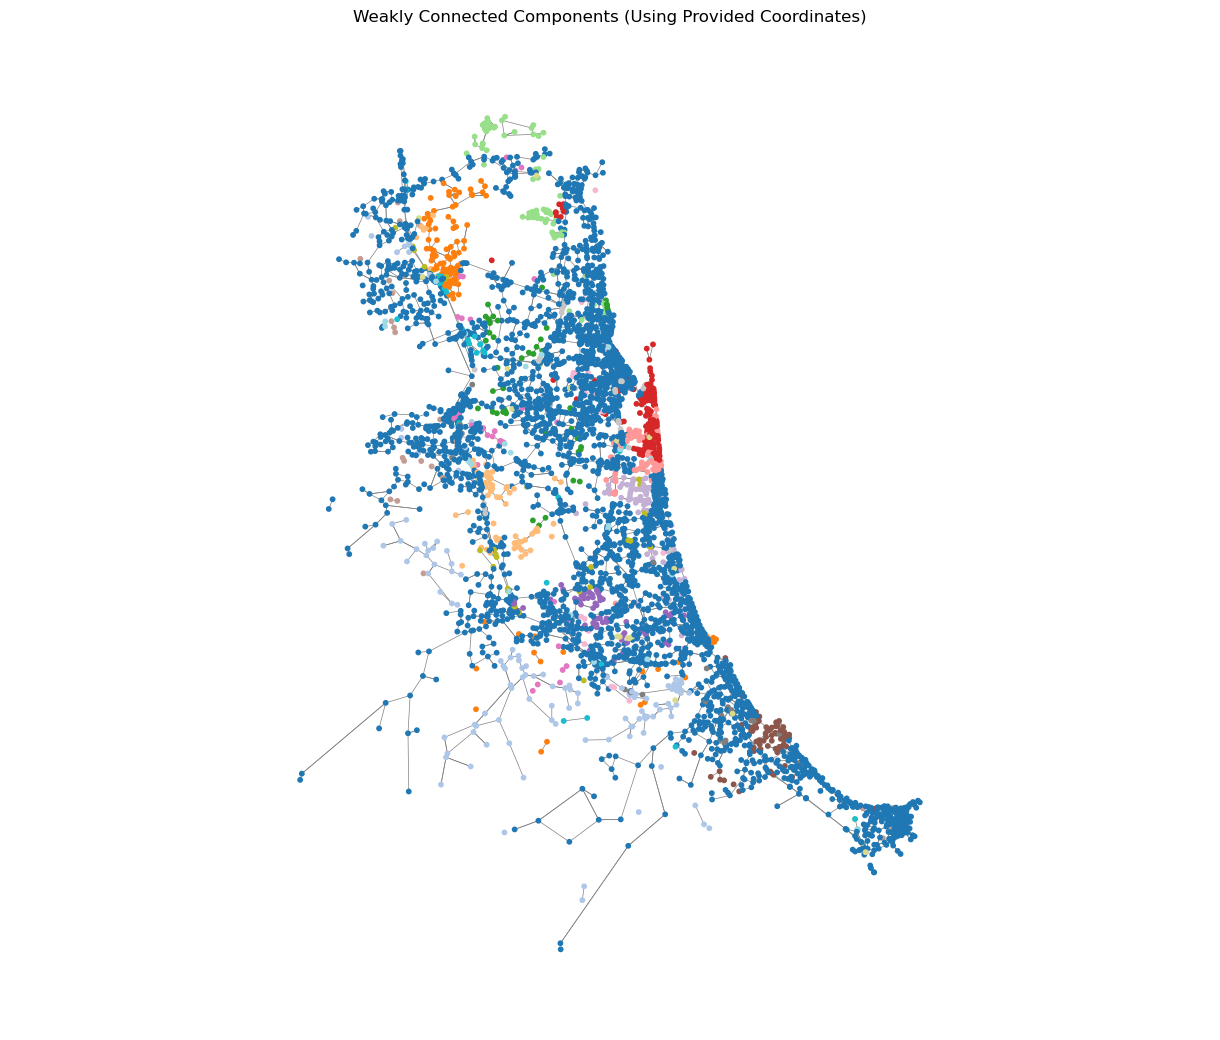

In [44]:
node_colors = [color_map[n] for n in graph.nodes()]

# plot
plt.figure(figsize=(12, 10))

nx.draw(
    graph,
    pos=pos,                      # ← your spatial layout
    node_color=node_colors,       # colors by component
    cmap=plt.cm.tab20,            # many distinct colors
    node_size=10,
    edge_color="gray",
    width=0.5,
    arrows = False,
    with_labels=False             # turn on if needed
)

plt.title("Weakly Connected Components (Using Provided Coordinates)")
plt.axis("equal")
plt.show()

In [14]:
def random_closure_track(graph, threshold=0.5):
    G = graph.copy()
    edgelist = list(G.edges())
    N = G.number_of_nodes()
    
    edge_removed_list = []
    gc_history = []      # <-- record giant component size
    iter = 0

    components = list(nx.weakly_connected_components(G))
    current_gc_size = max(len(c) for c in components)
    gc_history.append(current_gc_size / N)   # record initial ratio

    while current_gc_size >= threshold * N:
        edge_index = np.random.randint(len(edgelist))
        edge = edgelist.pop(edge_index)
        G.remove_edge(*edge)
        edge_removed_list.append(edge)
        iter += 1
        
        components = list(nx.weakly_connected_components(G))
        current_gc_size = max(len(c) for c in components)
        
        gc_history.append(current_gc_size / N)   # record updated ratio

    return iter, edge_removed_list, G, gc_history

iters, removed_edges, graph, gc_hist = random_closure_track(G_copy)

In [15]:
iters

4449

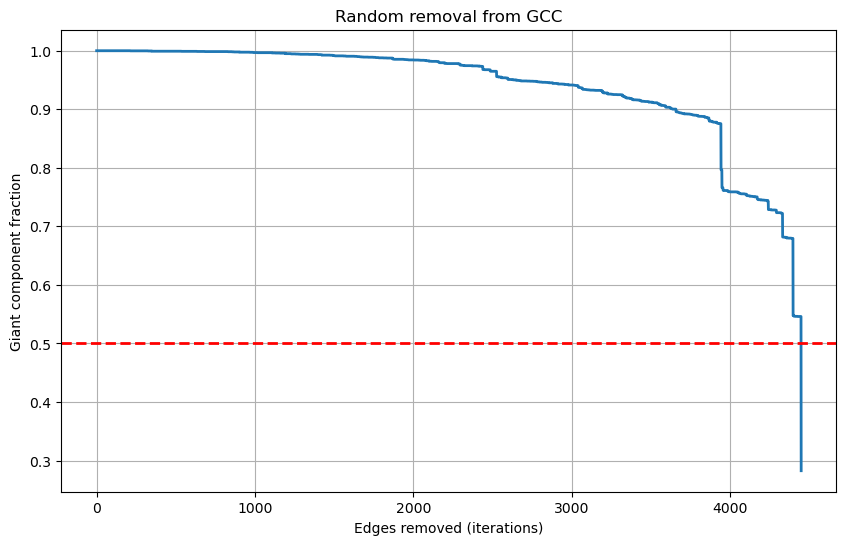

In [16]:
plt.figure(figsize=(10,6))
plt.plot(gc_hist, linewidth=2)
plt.axhline(0.5, linestyle="--", linewidth=2, color="Red")   # threshold line

plt.xlabel("Edges removed (iterations)")
plt.ylabel("Giant component fraction")
plt.title("Random removal from GCC")
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))

# 3a. Draw ALL nodes with component colors, and the *existing* edges (in the graph G)
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=10, # Increased size for better visibility of colors
    linewidths=0,
    arrows=False,
    node_color=color_map,  # <--- Use the new color list here
    edge_color="lightgray",  # Color the remaining edges faintly
    alpha=0.7,
)

# 3b. Overlay the removed edges in red
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=removed_edges, # Assuming removed_edges is the result of random_closure
    edge_color="red",
    style="-",
    arrows=False,
    width=2.5,        # thicker line to highlight
    alpha=0.9
)

plt.title(f"Network Disconnection: Two Components (Removed Edges in Red)")
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=20,
    linewidths=0,
    arrows=False,
    edge_color="gray",
    alpha=0.7,
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=removed_edges,
    edge_color="red",
    style="-",
    arrows=False,
    width=2.5,        # thicker line to highlight
    alpha=0.9
)

plt.title("Network Graph (Node Coordinates)")
plt.show()

In [19]:
def target_closure(graph):
    centrality = nx.edge_betweenness_centrality(graph)
    edgelist = list(graph.edges())
    iter = 0

    while nx.number_weakly_connected_components(graph) < 2:
        edge = max(centrality,key=centrality.get)
        graph.remove_edge(*edge)
        centrality = nx.edge_betweenness_centrality(graph, k=800)
        iter+=1
    return iter, list(nx.weakly_connected_components(graph))
        

In [20]:
iters, components = target_closure(G.copy())

In [22]:
components[1]

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [43]:
def get_gcc_ratio(G, initial_N):
    """
    Returns the fraction of nodes remaining in the 
    Giant Connected Component (GCC).
    """
    if len(G) == 0:
        return 0
    # Finding the largest component
    largest_cc = max(nx.connected_components(G), key=len)
    return len(largest_cc) / initial_N

def estimate_global_efficiency(G, num_samples=100):
    """
    Estimates Global Efficiency by sampling 'num_samples' random sources
    rather than calculating all pairs. 
    
    Efficiency = 1/d_ij. Disconnected nodes have efficiency 0.
    """
    N = len(G)
    if N < 2:
        return 0

    nodes = list(G.nodes())
    # If graph is small, just use all nodes. Otherwise sample.
    sources = random.sample(nodes, min(N, num_samples))
    
    efficiency_sum = 0
    
    for source in sources:
        # Get shortest paths from this source to ALL reachable nodes
        # This is much faster than doing pair-by-pair
        lengths = nx.single_source_shortest_path_length(G, source)
        
        # Calculate inverse distance for reachable nodes (excluding self)
        # If a node is not in 'lengths', it is disconnected (dist=inf, inv=0)
        inv_dists = [1/d for target, d in lengths.items() if target != source]
        efficiency_sum += sum(inv_dists)
    
    # Normalization formula for efficiency
    # We normalize by the number of possible pairs we COULD have checked
    # (num_samples * (N - 1))
    return efficiency_sum / (len(sources) * (N - 1))



def simulate_attack(G, attack_order, batch_size=10):
    """
    Removes nodes based on the attack_order list.
    Returns lists of (fraction_removed, gcc_size, efficiency).
    """
    H = G.copy()
    initial_N = len(H)
    
    results_removed = [0]
    results_gcc = [1.0] # Starts at 100%
    results_eff = [estimate_global_efficiency(H)]
    
    # Process in batches to speed up the loop
    # (Measuring after every single node removal is too slow for big graphs)
    for i in range(0, len(attack_order), batch_size):
        
        # Identify the batch of nodes to remove
        batch = attack_order[i : i + batch_size]
        H.remove_nodes_from(batch)
        
        # Record stats
        frac_removed = (i + len(batch)) / initial_N
        
        results_removed.append(frac_removed)
        results_gcc.append(get_gcc_ratio(H, initial_N))
        results_eff.append(estimate_global_efficiency(H))
        
        # Optimization: If graph is empty, stop
        if len(H) == 0:
            break
            
    return results_removed, results_gcc, results_eff

In [55]:
def strategic_closure_betweenness(graph, threshold=0.5):
    G = graph.copy()
    N = G.number_of_nodes()

    gc_hist = []        # fraction of nodes in GC after each removal
    iterations = 0

    # initial GC size
    components = list(nx.weakly_connected_components(G))
    current_gc_size = max(len(c) for c in components)
    gc_hist.append(current_gc_size / N)

    while current_gc_size >= threshold * N and G.number_of_edges() > 0:

        # compute edge betweenness centrality
        edge_bw = nx.edge_betweenness_centrality(G, normalized=True)

        # pick the edge with the highest betweenness
        edge_to_remove = max(edge_bw, key=edge_bw.get)

        # remove this most critical edge
        G.remove_edge(*edge_to_remove)
        iterations += 1

        # update GC size
        components = list(nx.weakly_connected_components(G))
        current_gc_size = max(len(c) for c in components)
        gc_hist.append(current_gc_size / N)

    return iterations, G, gc_hist


In [9]:
def strategic_closure_betweenness_efficient(graph, threshold=0.5, k=100):
    G = graph.copy()
    N = G.number_of_nodes()

    gc_hist = []
    iterations = 0

    # initial GC size
    components = list(nx.weakly_connected_components(G))
    current_gc = max(len(c) for c in components)
    gc_hist.append(current_gc / N)

    while current_gc >= threshold * N:
        # Approximate betweenness: samples k nodes
        bw = nx.edge_betweenness_centrality(G, k=k, seed=42, weight="Length")

        edge_to_remove = max(bw, key=bw.get)
        G.remove_edge(*edge_to_remove)
        iterations += 1

        components = list(nx.weakly_connected_components(G))
        current_gc = max(len(c) for c in components)
        gc_hist.append(current_gc / N)

    return iterations, G, gc_hist

In [24]:
def strategic_closure_corrected(graph, threshold=0.5, k=100):
    G = graph.copy()
    N = G.number_of_nodes()
    gc_hist = []
    iterations = 0

    # Initial GC size
    components = list(nx.weakly_connected_components(G))
    current_gc = max(len(c) for c in components)
    gc_hist.append(current_gc / N)

    while current_gc >= threshold * N:
        # Approximate betweenness
        # Use exact calculation if possible, as discussed previously, but keeping k=100 for consistency
        bw = nx.edge_betweenness_centrality(G, seed=42)

        # 1. Identify the directed edge to remove
        if not bw: # Check if all edges are gone
            break
        u, v = max(bw, key=bw.get)
        
        # --- CRITICAL MODIFICATION ---
        
        # 2. Remove the selected edge (u, v)
        if G.has_edge(u, v):
            G.remove_edge(u, v)
            
        # 3. Check for and remove the anti-parallel edge (v, u)
        if G.has_edge(v, u):
            G.remove_edge(v, u)
            
        # The iteration count now reflects physical road closures (1 iteration = 1 road closed)
        iterations += 2

        # Re-calculate WCC size
        components = list(nx.weakly_connected_components(G))
        current_gc = max(len(c) for c in components)
        gc_hist.append(current_gc / N)

    return iterations, G, gc_hist

In [11]:
G_copy = G.copy()
iters_bet, G_bet, gc_hist_bet = strategic_closure_betweenness_efficient(G_copy, k=100)

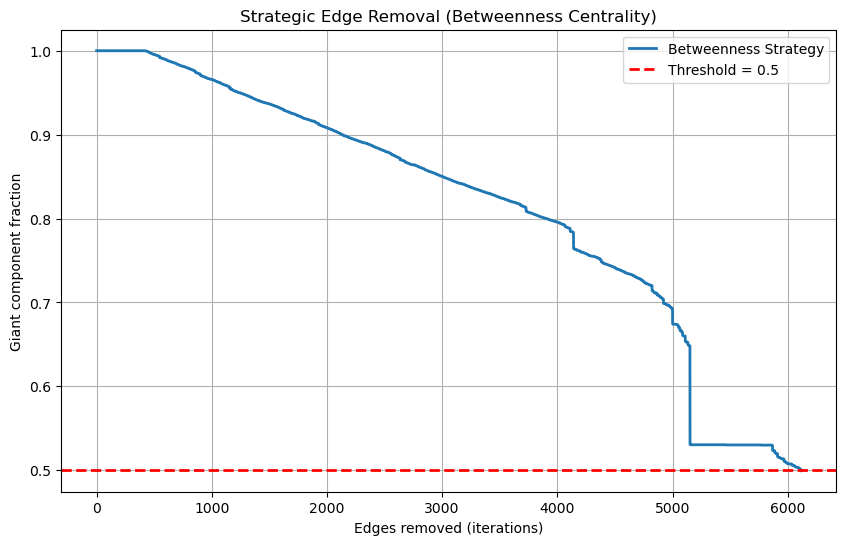

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(gc_hist_bet, linewidth=2, label="Betweenness Strategy")
plt.axhline(0.5, linestyle="--", linewidth=2, label="Threshold = 0.5", color="Red")

plt.xlabel("Edges removed (iterations)")
plt.ylabel("Giant component fraction")
plt.title("Strategic Edge Removal (Betweenness Centrality)")
plt.grid(True)
plt.legend()
plt.show()


In [13]:
iters_bet

6117

TA CODE

In [23]:
import networkx as nx
import itertools
from multiprocessing import Pool
import math # Added for a potentially cleaner way to calculate chunk size

def chunks(l, n):
    l_c = iter(l)
    while True:
        x = tuple(itertools.islice(l_c, n))
        
        # Corrected indentation and logic: check if the slice is empty
        if not x:
            return 
        
        yield x

def betweenness_centrality_parallel_edge(G, processes=None):
    # 1. Initialize the Pool
    p = Pool(processes=processes)
    
    # Use the actual number of processes available in the Pool
    num_processes = len(p._pool) 
    
    # 2. Divide nodes into chunks
    chunk_size = math.ceil(G.order() / num_processes) 
    node_chunks = list(chunks(G.nodes(), chunk_size))
    num_chunks = len(node_chunks)

    # 3. Parallel calculation
    # Uses nx.edge_betweenness_centrality_subset to calculate partial edge centrality
    bt_sc = p.starmap(
        nx.edge_betweenness_centrality_subset,
        zip(
            [G] * num_chunks,        # G: The graph
            node_chunks,             # sources: The chunk of nodes
            [list(G)] * num_chunks,  # targets: All nodes
            [True] * num_chunks,     # normalized: True
            ["Length"] * num_chunks, # weight: The edge attribute to use for shortest paths
        ),
    )
    
    # 4. Terminate the Pool
    p.close()
    p.join()

    #
    # Start with the first result
    bt_e = bt_sc[0]
    
    # Sum the remaining results
    for bt in bt_sc[1:]:
        for edge, centrality in bt.items():
            # Since edges in a directed graph are unique (u, v) != (v, u), 
            # we just sum the centralities for the edge tuple.
            bt_e[edge] += centrality
            
    return bt_e

In [20]:
G_copy = G.copy()
node_betweenness = betweenness_centrality_parallel_edge(G_copy, processes=4)

In [24]:
def strategic_closure_betweenness_efficient_parallel(graph, threshold=0.5, processes = None):
    G = graph.copy()
    N = G.number_of_nodes()

    gc_hist = []
    iterations = 0

    # initial GC size
    components = list(nx.weakly_connected_components(G))
    current_gc = max(len(c) for c in components)
    gc_hist.append(current_gc / N)

    while current_gc >= threshold * N:
        # Approximate betweenness: samples k nodes
        bw = betweenness_centrality_parallel_edge(G, processes=processes)

        edge_to_remove = max(bw, key=bw.get)
        G.remove_edge(*edge_to_remove)
        iterations += 1

        components = list(nx.weakly_connected_components(G))
        current_gc = max(len(c) for c in components)
        gc_hist.append(current_gc / N)

    return iterations, G, gc_hist

In [27]:
G_copy = G.copy()
iter, G_re, gc_hist = strategic_closure_betweenness_efficient_parallel(G_copy, processes=4)

In [32]:
iter

2426

In [29]:
node_betweenness[1]

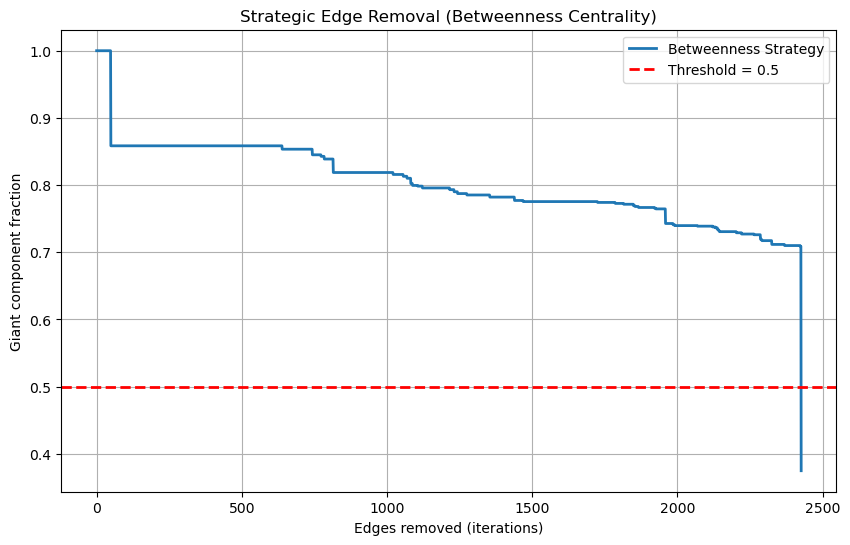

In [33]:
plt.figure(figsize=(10, 6))

plt.plot(gc_hist, linewidth=2, label="Betweenness Strategy")
plt.axhline(0.5, linestyle="--", linewidth=2, label="Threshold = 0.5", color="Red")

plt.xlabel("Edges removed (iterations)")
plt.ylabel("Giant component fraction")
plt.title("Strategic Edge Removal (Betweenness Centrality)")
plt.grid(True)
plt.legend()
plt.show()
